## Lesson6: pets revisited

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *

In [2]:
torch.cuda.set_device(1)

In [3]:
bs = 64

In [4]:
path = untar_data(URLs.PETS)/'images' 

## Data augmentation

In [5]:
tfms = get_transforms(max_rotate=20, max_zoom = 1.3,max_lighting=0.4,max_warp=0.4,p_affine=1.,p_lighting=1.)

In [6]:
doc(get_transforms)

get_transforms [source] [test] get_transforms ( do_flip : bool = True , flip_vert : bool = False , max_rotate : float = 10.0 , max_zoom : float = 1.1 , max_lighting : float = 0.2 , max_warp : float = 0.2 , p_affine : float = 0.75 , p_lighting : float = 0.75 , xtra_tfms : Optional [ Collection [ Transform ]]= None ) → Collection [ Transform ] 
 
 × Tests found for get_transforms : pytest -sv tests/test_vision_data.py::test_image_to_image_different_tfms [source] pytest -sv tests/test_vision_data.py::test_image_to_image_different_y_size [source] To run tests please refer to this guide . Utility func to easily create a list of flip, rotate, zoom , warp, lighting transforms. 
 Show in docs

In [7]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [8]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [9]:
data = get_data(224, bs, 'zeros')

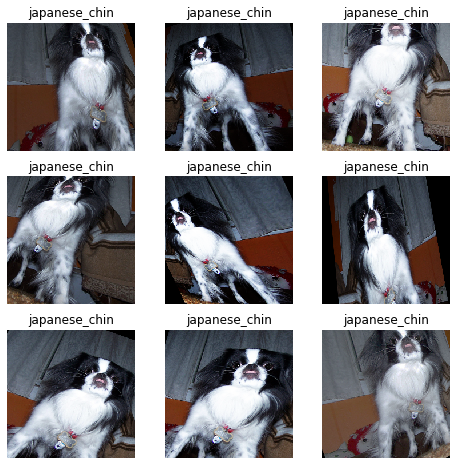

In [10]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [11]:
data = get_data(224,bs)

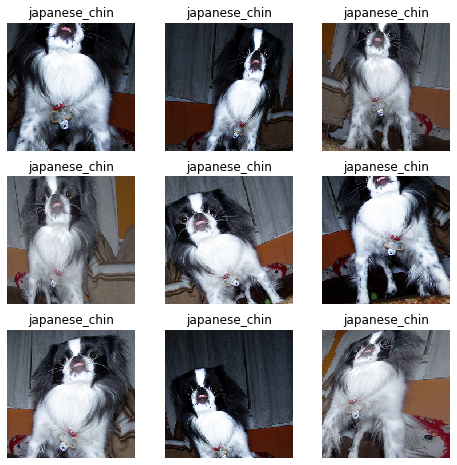

In [12]:
plot_multi(_plot, 3, 3, figsize=(8,8))

## Train a model

In [13]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

In [14]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


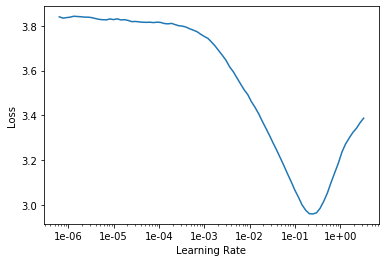

In [15]:
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(3,slice(1e-2),pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,2.471581,1.201084,0.273342,00:13
1,1.447112,0.330231,0.077808,00:13
2,0.898245,0.270573,0.075101,00:13


In [17]:
learn.unfreeze()
learn.fit_one_cycle(2,max_lr=slice(1e-6,1e-3),pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.686355,0.279162,0.060893,00:16
1,0.653722,0.273289,0.057510,00:16


In [18]:
data = get_data(352,bs)
learn.data = data

In [19]:
learn.fit_one_cycle(2,max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.615770,0.257403,0.052097,00:38
1,0.580448,0.256501,0.050068,00:36


In [20]:
learn.save('352')

## Convolution kernel 

In [21]:
data = get_data(352,16) 

In [22]:
learn = cnn_learner(data,models.resnet34,metrics=error_rate, bn_final=True).load('352')

Category american_pit_bull_terrier

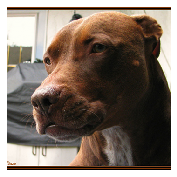

In [23]:
idx = 0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [24]:
k = tensor([
    [0.,-5/3,1],
    [-5/3,-5/3,1],
    [1.,1,1],
]).expand(1,3,3,3)/6

In [25]:
from fastai.callbacks.hooks import *

In [26]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [27]:
k.shape

torch.Size([1, 3, 3, 3])

In [28]:
t = data.valid_ds[0][0].data; t.shape #the image

torch.Size([3, 352, 352])

In [29]:
t[None].shape #Mini batch of one image

torch.Size([1, 3, 352, 352])

In [30]:
edge = F.conv2d(t[None],k)

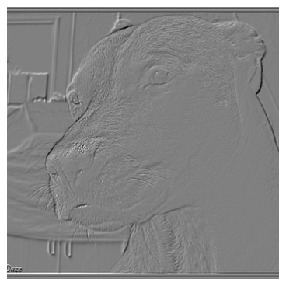

In [31]:
show_image(edge[0],figsize=(5,5))

In [32]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [33]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
___________________________________________________

## Heatmap

In [34]:
m = learn.model.eval()

In [35]:
xb,_=data.one_item(x) #mini batch -->normalize
xb_im=Image(data.denorm(xb)[0])
xb=xb.cuda() #on the gpu

In [36]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a:
        with hook_output(m[0],grad=True) as hook_g:
            preds=m(xb)
            preds[0,int(cat)].backward()
        return hook_a,hook_g

In [37]:
hook_a,hook_g = hooked_backward()

In [38]:
acts = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [39]:
avg_acts = acts.mean(0)

In [40]:
avg_acts.shape

torch.Size([11, 11])

In [41]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

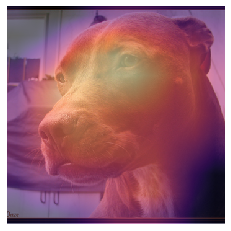

In [42]:
show_heatmap(avg_acts)